**Introduction**

In this project, I analyze Yelp reviews to understand customer sentiment at the business and city level.
I go beyond raw sentiment by identifying themes that contribute to high or low positivity rates.
The goal is to spot strong vs. weak business locations, helping managersB prioritize improvements and focus on high-traffic areas with growth potential.

In [84]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd


# Reading part of the reviews
reviews_iter = pd.read_json(
    "/content/drive/MyDrive/Yelp/yelp_academic_dataset_review.json",
    lines=True,
    chunksize=50000  # to read in chunks
)

reviews = next(reviews_iter)  # take only first 50k reviews


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# Load businesses dataset
business = pd.read_json(
    "/content/drive/MyDrive/Yelp/yelp_academic_dataset_business.json",
    lines=True)


In [86]:
print(business.columns)


Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


In [87]:
reviews.columns


Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

**Data Preparation**

I worked with the Yelp reviews dataset (50,000 reviews) and business metadata.
I kept only the relevant columns:
business_id, name, city, state, stars, text, and date.

In [88]:
# Merge reviews with business info
df = reviews.merge(
    business[['business_id', 'name', 'city', 'state', 'latitude', 'longitude']],
    on='business_id',
    how='left'
)

# Keeping relevant columns
df = df[['business_id', 'name', 'city', 'state', 'stars', 'text','date']]
df.head()

,business_id,name,city,state,stars,text,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,Turning Point of North Wales,North Wales,PA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,7ATYjTIgM3jUlt4UM3IypQ,Body Cycle Spinning Studio,Philadelphia,PA,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,YjUWPpI6HXG530lwP-fb2A,Kettle Restaurant,Tucson,AZ,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,kxX2SOes4o-D3ZQBkiMRfA,Zaika,Philadelphia,PA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,e4Vwtrqf-wpJfwesgvdgxQ,Melt,New Orleans,LA,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [89]:
#converting date column to datetime for time series analysis
df['date'].dtype
df["date"] = pd.to_datetime(df["date"])


In [90]:

# extract just the date part, but keep it as datetime64[ns]
df["date"] = df["date"].dt.normalize()   # sets time to 00:00:00


In [91]:
# Sample 2000 reviews to test pipeline
sample_df = df.sample(2000, random_state=42).reset_index(drop=True)
sample_df.head()


,business_id,name,city,state,stars,text,date
0,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,Santa Barbara,CA,3,Great location but the place is very tiny. Y...,2017-09-12
1,r43DrfYAbAgifsYyNkljZw,Red Hot & Blue Restaurant,Cherry Hill,NJ,1,WARNING: HORRIBLE!\n\nI absolutely love BBQ an...,2015-03-05
2,Y2rYM2crYfTC25y6iquPgw,Landmark Americana,Wayne,PA,5,I stopped in for dinner and a drink & was thor...,2015-08-30
3,2er_V-oAd7IbQ5YTY56r7A,Bareburger - Midtown Village,Philadelphia,PA,4,If you're looking for fresh spins on the class...,2018-04-04
4,FrjN8iGJBqRWhLW2E1brAg,Schnucks Telegraph,St. Louis,MO,1,We purchased the 8 piece fried chicken from th...,2017-08-19


**Sentiment Analysis**

I applied a Hugging Face model,
distilbert-base-uncased-finetuned-sst-2-english,
to classify each review as POSITIVE or NEGATIVE and assign a confidence score.

In [92]:
!pip install transformers --quiet
from transformers import pipeline


# Explicit model name (better practice!)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

sentiment_analyzer = pipeline("sentiment-analysis", model=model_name, device=0)

# Performing sentiment analysis in batches for efficiency
results = sentiment_analyzer(
    sample_df['text'].str[:512].tolist(),
    batch_size=32
)

sample_df['sentiment'] = [r['label'] for r in results]
sample_df['sentiment_score'] = [r['score'] for r in results]



Device set to use cuda:0


**Business-Level Aggregation**

I grouped reviews by business (business_id, name, city, state) to compute:


*   Total reviews per business

*   Positive vs. negative review counts


*   Average sentiment score

*   Positive percent (share of positive reviews)










In [93]:
#Aggregating reviews for each business in each city
business_summary = sample_df.groupby(
    ['business_id', 'name', 'city', 'state']
).agg(
    total_reviews=('text', 'count'),
    positive_reviews=('sentiment', lambda x: (x=='POSITIVE').sum()),
    negative_reviews=('sentiment', lambda x: (x=='NEGATIVE').sum()),
    avg_sentiment_score=('sentiment_score', 'mean')
).reset_index()

#Creating a positive percent score column to identify businesses according by positivity score where < 50 mean negative
business_summary['positive_percent'] = 100 * business_summary['positive_reviews'] / business_summary['total_reviews']
business_summary.sort_values(by='total_reviews', ascending=False).head(60)


,business_id,name,city,state,total_reviews,positive_reviews,negative_reviews,avg_sentiment_score,positive_percent
387,GBTPC53ZrG1ZBY3DT8Mbcw,Luke,New Orleans,LA,22,21,1,0.984793,95.454545
557,PY9GRfzr4nTZeINf346QOw,Peppermill Reno,Reno,NV,11,10,1,0.991491,90.909091
893,d_tRshM-w6S4QxE4VVi8tQ,Jones,Philadelphia,PA,9,8,1,0.999494,88.888889
1295,vN6v8m4DO45Z4pp8yxxF_w,Surrey's Café & Juice Bar,New Orleans,LA,9,7,2,0.965040,77.777778
769,Z5po0aTuzKKblek5y6Sp8Q,500 Degrees,Philadelphia,PA,8,4,4,0.997339,50.000000
229,8uF-bhJFgT4Tn6DTb27viA,District Donuts Sliders Brew,New Orleans,LA,8,8,0,0.952518,100.000000
665,UCMSWPqzXjd7QHq7v8PJjQ,Prep & Pastry,Tucson,AZ,7,6,1,0.940709,85.714286
1014,jMZ56S8Y1t7cA1Ob-d-qeA,Three Muses,New Orleans,LA,7,6,1,0.999602,85.714286
705,W4ZEKkva9HpAdZG88juwyQ,Mr. B's Bistro,New Orleans,LA,7,6,1,0.991009,85.714286
782,Zx7n8mdt8OzLRXVzolXNhQ,Milk and Honey Nashville,Nashville,TN,7,5,2,0.998961,71.428571


**City-Level Aggregation**

I then grouped by city and state to calculate:


*   Total review volume per city

*   Average positivity rate across business





In [94]:
# A city summary in each state

city_summary = business_summary.groupby(['city','state']).agg(
    total_reviews=('total_reviews', 'sum'),
    positive_percent=('positive_percent', 'mean')
).reset_index()



**Filtering for Reliability**

To avoid noise, I only kept cities with at least 5 reviews for both the top and bottom performers.

In [95]:
# Top 10 stores by positivity sorted by those with multiple reviews first
top_summary= city_summary.sort_values(by=['total_reviews','positive_percent'], ascending=False)

#Filter cities with at least 5 reviews ( to remove noise)
top_summary = top_summary[top_summary['total_reviews'] >= 5].head(10)

top_summary

,city,state,total_reviews,positive_percent
150,Philadelphia,PA,370,76.958025
136,New Orleans,LA,227,79.957956
133,Nashville,TN,146,68.445539
190,Tampa,FL,116,69.550562
92,Indianapolis,IN,104,75.586854
157,Reno,NV,102,74.219114
199,Tucson,AZ,92,77.308802
166,Saint Louis,MO,81,71.194444
169,Santa Barbara,CA,74,77.403846
58,Edmonton,AB,32,74.712644


**Top Cities**

The top 10 cities with strong positivity rates and review volumes highlight potential role models for best practices.
Example: New Orleans, Louisiana,and Philadelphia, Pennsylvania had the highest traffic and over 75% positivity. This indicates further growth opportunities.

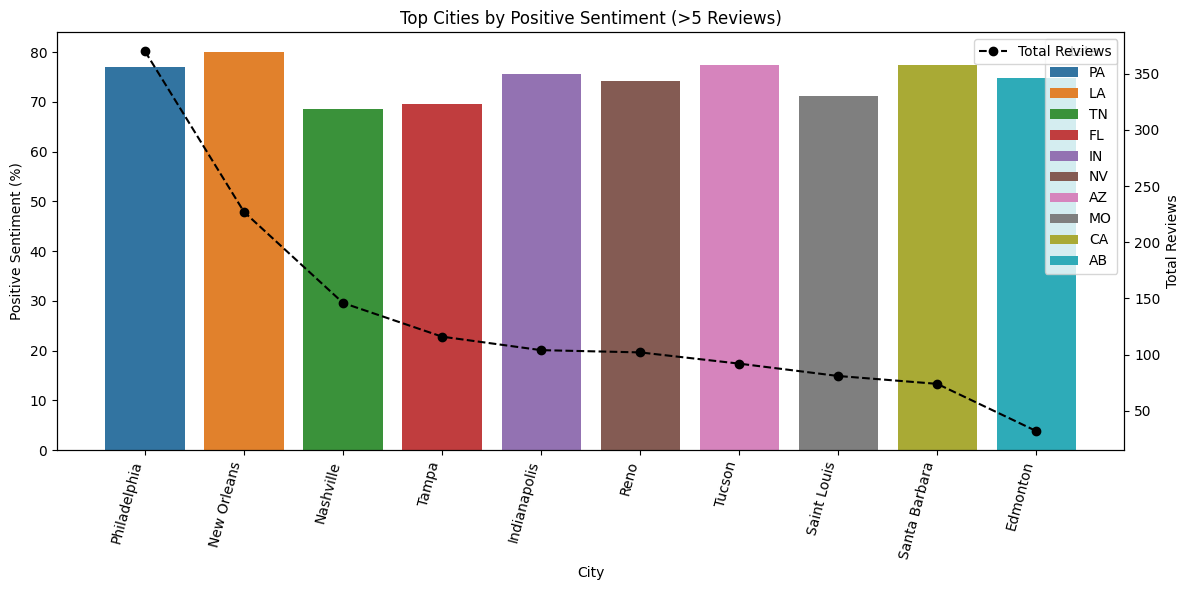

In [96]:
#A plot of cities with high positivity score and total reviews axes to find cities with high volume and positive reviews
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax1 = plt.subplots(figsize=(12,6))

# First axis: Positive sentiment %
sns.barplot(
    data=top_summary,
    x='city', y='positive_percent',
    hue='state',
    dodge=False,
    palette='tab10',
    order=top_summary['city'],
    ax=ax1
)

# Label for first axis
ax1.set_ylabel("Positive Sentiment (%)")
ax1.set_xlabel("City")
ax1.set_title("Top Cities by Positive Sentiment (>5 Reviews)")

# Rotate x labels
plt.setp(ax1.get_xticklabels(), rotation=75, ha='right')

# Secondary axis: Total reviews
ax2 = ax1.twinx()
ax2.plot(
    top_summary['city'],
    top_summary['total_reviews'],
    color='black', marker='o', linestyle='--', label='Total Reviews'
)

ax2.set_ylabel("Total Reviews")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [97]:
#Finding bottom 10 businesses sorted by total reviews(desc) and positive percent (asc) to find least liked businesses
bottom_summary = city_summary.sort_values(['total_reviews','positive_percent'], ascending=[False, True]) # Fixed the repeated ascending argument
bottom_summary = bottom_summary[bottom_summary['positive_percent'] < 50].head(10)
bottom_summary


,city,state,total_reviews,positive_percent
191,Tarpon Springs,FL,8,42.857143
162,Royersford,PA,4,25.000000
2,Antioch,TN,3,0.000000
99,King of Prussia,PA,3,33.333333
134,New Castle,DE,3,33.333333
138,Newark,DE,3,33.333333
156,Port Richey,FL,3,33.333333
192,Temple Terrace,FL,3,33.333333
64,Fenton,MO,2,0.000000
77,Green Valley,AZ,2,0.000000


**Bottom Cities**

The bottom 10 cities reveal locations where customer dissatisfaction is concentrated.

Example: Florida stood out negatively: 3 of the lowest-scoring cities came from this state, suggesting systemic issues that may require policy or structural changes at the regional level.

<Figure size 1000x600 with 0 Axes>

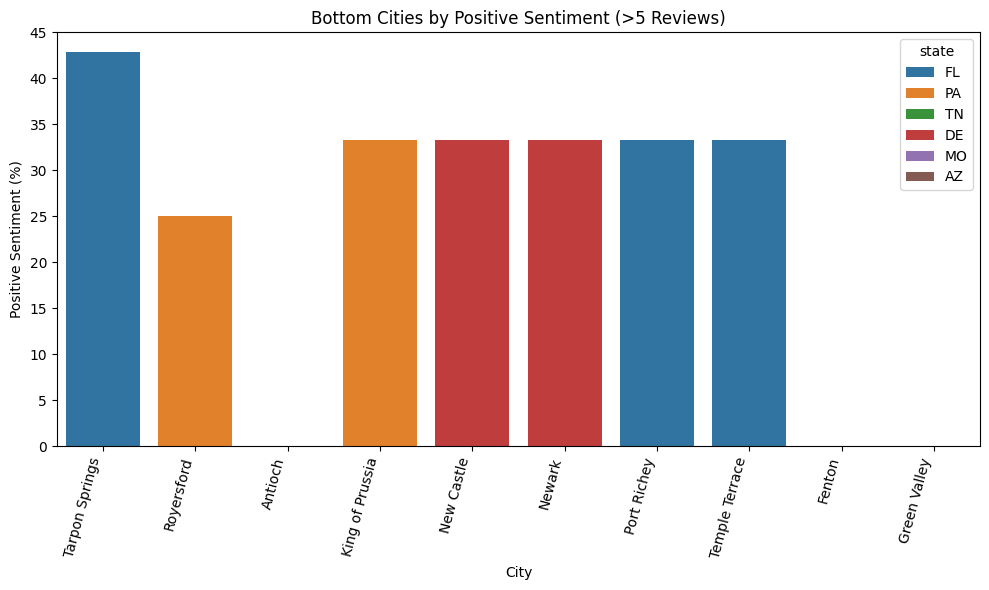

In [98]:
#A plot of cities with lowest positivity score to find cities with high volume (> 5 reviews) and least positve reviews

ax3 = plt.figure(figsize=(10,6))

# Plot for bottom cities by positive sentiment
fig, ax3 = plt.subplots(figsize=(10,6))
sns.barplot(
    data=bottom_summary,
    x='city', y='positive_percent',
    hue='state',
    dodge=False,
    palette='tab10',
    order=bottom_summary['city'],
    ax=ax3
)

# Label for axis3
ax3.set_ylabel("Positive Sentiment (%)")
ax3.set_xlabel("City")
ax3.set_title("Bottom Cities by Positive Sentiment (>5 Reviews)")

# Rotate x labels
plt.setp(ax3.get_xticklabels(), rotation=75, ha='right')


plt.tight_layout()
plt.show()

**Zero-Shot Classification**

Model: facebook/bart-large-mnli

Automatically categorized reviews into themes such as Service, Pricing, Product Quality, Atmosphere, Staff

Allowed deeper insights into why cities and businesses scored high or low in positivity

In [99]:
# Classifying success factors of top cities with multiple reviews and high positivity (High volume = Likely Areas for Improvement)
#1 New Orleans (Louisiana)
new_orleans = sample_df[sample_df['city']=='New Orleans']
new_orleans


from transformers import pipeline

zero_shot= pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

labels = [
    "good service", "bad service",
    "cleanliness", "dirty environment",
    "high product quality", "poor product quality",
    "friendly staff", "rude staff",
    "reasonable pricing", "overpriced",
    "good location", "bad location"
]
# Taking a subset of reviews for Kenner
orleans_reviews = new_orleans[['name', 'text']].tail(10)  # sample first 10 reviews

for n, row in orleans_reviews.iterrows():
    business_name = row['name']
    review_text = row['text']

    result = zero_shot(review_text, candidate_labels=labels, multi_label=True)

    print(f"\nBusiness name: {business_name}")
    print(f"Review: {review_text}")
    print("Top Labels:", result["labels"][:3])
    print("Scores:", result["scores"][:3])




Device set to use cuda:0



Business name: Mena's Palace
Review: This was the worst stop of my entire trip. No room to sit, and please don't use the bathroom. Its a 2x2 sweat box from the kitchen and you couldn't move sideways in there if you wanted to. They false advertise for half of their menu. Example:
"Ham and cheese omelet with your choice of toast, bagel or grits, 2.99"
Wow "Ill take it you reply." You get your bill 10.00. Scratching your head you ask "how that could be?" The answer, the cheese cost a 1.00 the bread 3.00 and so on. Shoot I'm surprised they didn't charge for the egg too. To top it off the food tasted like s#$% ran over twice. I could cook a better breakfast if I was drunk on bourbon st. Honestly, service was crap, it took two hours for a Dennys breakfast and it was off a street I couldnt even find. LAME
Top Labels: ['poor product quality', 'bad service', 'dirty environment']
Scores: [0.9975377917289734, 0.9962462186813354, 0.9898550510406494]

Business name: Luke
Review: Really awesome, oy

In [100]:
#2 Philadelphia (Pennsylvania)
philadephia = sample_df[sample_df['city']=='Philadelphia']

# Taking a subset of reviews for Philadelphia
philadephia_reviews = philadephia[['name', 'text']].head(10)  # sample first 10 reviews

for p, row in philadephia_reviews.iterrows():
    business_name = row['name']
    review_text = row['text']

    result = zero_shot(review_text, candidate_labels=labels, multi_label=True)

    print(f"\nBusiness name: {business_name}")
    print(f"Review: {review_text}")
    print("Top Labels:", result["labels"][:3])
    print("Scores:", result["scores"][:3])


Business name: Bareburger - Midtown Village
Review: If you're looking for fresh spins on the classic burger, this place is for you. Huge fan of the firequacker and the onion rings. Oh and did I mention their milkshakes are incredibleeee! The service is quick and the food is fresh every time! This place is fire.
Top Labels: ['high product quality', 'good service', 'friendly staff']
Scores: [0.987759530544281, 0.9829922914505005, 0.9688649773597717]

Business name: La Creperie Cafe
Review: Just getting around to writing this review.  We went on Valentines day.  It was real nice with the French atmosphere.  I liked the savory crepes better than the sweet.  We had the Gyro Crepe and the Asiago Crepe, both were delicious.  We didn't try the Nanza but we will go back for that, they are flatbreads on iIndain Nan bread they sound great.  Wee ended on the Crepe suzette.  The service was excellent.  We will go back.
Top Labels: ['good location', 'good service', 'friendly staff']
Scores: [0.9977

In [101]:
# Finding poor factors of bottom cities with multiple reviews and low positivity
#1 Tarpon Springs (Florida)
tarpon_springs = sample_df[(sample_df['city']=='Tarpon Springs') & (sample_df['sentiment']=="NEGATIVE")]

# Taking a relevant columns
tarpon_reviews = tarpon_springs[['name', 'text']]  # sample first 10 reviews

for t, row in tarpon_springs.iterrows():
    business_name = row['name']
    review_text = row['text']

    result = zero_shot(review_text, candidate_labels=labels, multi_label=True)

    print(f"\nBusiness name: {business_name}")
    print(f"Review: {review_text}")
    print("Top Labels:", result["labels"][:3])
    print("Scores:", result["scores"][:3])


Business name: Twistee Treat - Tarpon Springs
Review: Word to wise don't expect good service as the staff doesn't make an effort to get your order right.  Also you're better off ordering the kiddie size as I ordered a kiddie size for my son and I ordered a medium for me and basically my son had more ice cream.  So why pay for a medium,  this is the third time they gave me less then a kiddie size.  The awful service plus getting them to correct their mistake is just too aggravating, you absolutely need to have them repeat your back twice as they are not too bright.
Top Labels: ['bad service', 'rude staff', 'overpriced']
Scores: [0.9989443421363831, 0.9978340268135071, 0.9530583620071411]

Business name: Hellas Restaurant
Review: Our Scene:
Its a sunny, humid, middle of the week day in Tampa FL. Beth T and companion are sitting around doing nothing.

Me (beth t): I'm bored. 
Companion: Me too. Let's do something.
Me: OK. What?
Companion: I dunno.
Me (brilliant idea flashing): Let's try 

In [102]:
#2 Royersford (Pennsylvania)
royersford = sample_df[(sample_df['city']=='Royersford') & (sample_df['sentiment']=="NEGATIVE")]
royersford_reviews = royersford[['name','text']]

for r, row in royersford_reviews.iterrows():
    business_name = row['name']
    review_text = row['text']
    result = zero_shot(review_text, candidate_labels=labels, multi_label=True)
    print(f"\nBusiness name: {business_name}")
    print(f"Review: {review_text}")
    print("Top Labels:", result["labels"][:3])
    print("Scores:", result["scores"][:3])



Business name: Wawa
Review: Probably the cleanest Wawa I've ever been to. Fast, polite service. There is a gas station as well. Not busy here at all too! Wish Philly had one like this.
Top Labels: ['friendly staff', 'cleanliness', 'good service']
Scores: [0.9979157447814941, 0.9954978227615356, 0.9954806566238403]

Business name: Dairy Queen
Review: If there was a zero star rating that's how I would rate this location. 
It is the worst ice cream ever. Not sure how the ice cream is mixed but it is NOT creamy. The ice cream is like eating air. Ewwww.
Top Labels: ['poor product quality', 'bad location', 'bad service']
Scores: [0.9975428581237793, 0.9975100755691528, 0.965289294719696]

Business name: Barrister's Bagels
Review: Just an average bagel place. My breakfast sandwich hit the spot (bacon egg and cheese on a blueberry bagel), but my boyfriend's hash brown was mushy. Service was average and the line was confusing for someone who has never been here before. The line starts to the r

In [103]:
business_summary.to_csv("business_sentiment_summary.csv", index=False)
city_summary.to_csv("city_sentiment_summary.csv", index=False)
sample_df.to_csv("review_sentiments_sample.csv", index=False)
